In [52]:
# importing important libraries.
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# import all english stopwords from nltk.
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Importing Dataset
df = pd.read_csv('articles_bbc_2018_01_30.csv')
df.head()

,articles,lang
0,Image copyright PA/EPA Image caption Oligarch ...,en
1,Husband admits killing French jogger\r\n\r\nTh...,en
2,Media playback is unsupported on your device M...,en
3,Manchester City's Leroy Sane is ruled out for ...,en
4,Image copyright AFP Image caption Sebastien Br...,en


In [58]:
df.shape

(309, 2)

In [4]:
#checking unique target names.
df.lang.unique()

array(['en', 'fr', 'uk', 'hi', nan, 'de', 'ru', 'pt', 'id', 'tr', 'vi',
       'fa', 'es', 'sw', 'ar'], dtype=object)

In [59]:
#checking for missing values.
df.isnull().sum()

articles    1
lang        1
dtype: int64

### Text Preprocessing

In [13]:
# Remove emails and newline characters
# Convert to list and dropna values.
data = df.articles.dropna().values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[:1]

['Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list Russian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people. The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election. However, the US stressed those named were not subject to new sanctions. Mr Putin said the list was an unfriendly act that complicated US-Russia ties but he said he did not want to escalate the situation. Mr Putin said Russia should instead be thinking about "ourselves and the economy". The list was also derided by a number of senior Russian officials who said it bore a strong resemblance to the Forbes magazine ranking of Russian billionaires. A US Treasury Department later told Buzzfeed that an unclassified annex of the report had been derived from the magazine. Why did the US publish the list? The government

In [14]:
# Tokenize words and Clean-up text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['image', 'copyright', 'pa', 'epa', 'image', 'caption', 'oligarch', 'roman', 'abramovich', 'and', 'pm', 'dmitry', 'medvedev', 'are', 'on', 'the', 'list', 'russian', 'president', 'vladimir', 'putin', 'says', 'list', 'of', 'officials', 'and', 'businessmen', 'close', 'to', 'the', 'kremlin', 'published', 'by', 'the', 'us', 'has', 'in', 'effect', 'targeted', 'all', 'russian', 'people', 'the', 'list', 'names', 'top', 'russians', 'as', 'part', 'of', 'sanctions', 'law', 'aimed', 'at', 'punishing', 'moscow', 'for', 'meddling', 'in', 'the', 'us', 'election', 'however', 'the', 'us', 'stressed', 'those', 'named', 'were', 'not', 'subject', 'to', 'new', 'sanctions', 'mr', 'putin', 'said', 'the', 'list', 'was', 'an', 'unfriendly', 'act', 'that', 'complicated', 'us', 'russia', 'ties', 'but', 'he', 'said', 'he', 'did', 'not', 'want', 'to', 'escalate', 'the', 'situation', 'mr', 'putin', 'said', 'russia', 'should', 'instead', 'be', 'thinking', 'about', 'ourselves', 'and', 'the', 'economy', 'the', 'list'

In [15]:
# Creating unigrams

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['image_copyright_pa', 'epa_image_caption', 'oligarch', 'roman', 'abramovich', 'and', 'pm', 'dmitry', 'medvedev', 'are', 'on', 'the', 'list', 'russian', 'president', 'vladimir_putin', 'says', 'list', 'of', 'officials', 'and', 'businessmen', 'close', 'to', 'the', 'kremlin', 'published', 'by', 'the', 'us', 'has', 'in', 'effect', 'targeted', 'all', 'russian', 'people', 'the', 'list', 'names', 'top', 'russians', 'as', 'part', 'of', 'sanctions', 'law', 'aimed', 'at', 'punishing', 'moscow', 'for', 'meddling', 'in', 'the', 'us', 'election', 'however', 'the', 'us', 'stressed', 'those', 'named', 'were', 'not', 'subject', 'to', 'new', 'sanctions', 'mr', 'putin', 'said', 'the', 'list', 'was', 'an', 'unfriendly', 'act', 'that', 'complicated', 'us', 'russia', 'ties', 'but', 'he', 'said', 'he', 'did', 'not', 'want', 'to', 'escalate', 'the', 'situation', 'mr', 'putin', 'said', 'russia', 'should', 'instead', 'be', 'thinking', 'about', 'ourselves', 'and', 'the', 'economy', 'the', 'list', 'was', 'also',

In [17]:
# Remove Stopwords, Make Bigrams and Lemmatize

In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


In [20]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [21]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['pa', 'epa', 'image_caption', 'oligarch', 'roman', 'pm', 'dmitry', 'medvedev', 'list', 'russian', 'president', 'say', 'list', 'official', 'businessman', 'close', 'kremlin', 'publish', 'effect', 'target', 'russian', 'people', 'list', 'name', 'top', 'russian', 'part', 'sanction', 'law', 'aim', 'punish', 'moscow', 'meddle', 'election', 'however', 'stress', 'name', 'new', 'sanction', 'putin', 'say', 'list', 'unfriendly', 'act', 'complicate', 'russia', 'tie', 'say', 'want', 'escalate', 'situation', 'mr', 'putin', 'say', 'russia', 'instead', 'think', 'economy', 'list', 'also', 'deride', 'number', 'senior', 'russian', 'official', 'say', 'bore', 'strong', 'resemblance', 'forbe', 'magazine', 'rank', 'russian', 'billionaire', 'department', 'later', 'tell', 'buzzfeed', 'unclassified', 'annex', 'report', 'derive', 'magazine', 'publish', 'list', 'government', 'require', 'draw', 'list', 'congress', 'pass', 'counter', 'america', 'adversary', 'sanction', 'act', 'caatsa', 'august', 'law', 'aim', 'pun

In [22]:
# create a dictionary which will be the input for LDA model

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 2), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 2), (43, 1), (44, 5), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 4), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 3), (80, 1), (81, 1), (82, 2), (83, 1), (84, 2), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 2), (94, 1), (95, 1), (96, 3), (97, 1), (98, 1), (99, 3), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 3), (108, 1), (109, 1), (110, 2)

In [24]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accept', 1),
  ('accuse', 1),
  ('act', 4),
  ('action', 2),
  ('activity', 2),
  ('add', 2),
  ('administration', 1),
  ('adversary', 1),
  ('affair', 1),
  ('aggressive', 1),
  ('aim', 2),
  ('alexander', 1),
  ('alexei', 2),
  ('alisher', 1),
  ('allegation', 1),
  ('allege', 1),
  ('ally', 1),
  ('already', 1),
  ('also', 2),
  ('america', 1),
  ('american', 1),
  ('amount', 1),
  ('analysis', 1),
  ('annex', 1),
  ('apparently', 1),
  ('argue', 1),
  ('arsenal', 1),
  ('associate', 1),
  ('association', 1),
  ('attach', 1),
  ('attempt', 1),
  ('august', 2),
  ('bank', 1),
  ('banker', 1),
  ('bbc', 1),
  ('become', 1),
  ('benefit', 1),
  ('billion', 1),
  ('billionaire', 1),
  ('bore', 1),
  ('bortnikov', 1),
  ('business', 2),
  ('businessman', 2),
  ('buzzfeed', 1),
  ('caatsa', 5),
  ('call', 1),
  ('cancel', 1),
  ('caption', 1),
  ('chelsea', 1),
  ('chief', 3),
  ('claim', 1),
  ('classified', 1),
  ('close', 3),
  ('club', 1),
  ('comment', 1),
  ('committee', 1),
  (

# Model building and evaluting.

In [25]:
select_topics = []
for i in [5, 10, 15, 20, 30, 40]:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)


    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

    select_topics.append({"No of Topics": i, "Coherence Score": coherence_lda})


Perplexity:  -8.698810013136784

Coherence Score:  0.3889036918176538

Perplexity:  -8.833070634071289

Coherence Score:  0.43232169006553595

Perplexity:  -12.334597744109269

Coherence Score:  0.42723876001475847

Perplexity:  -13.927770626334379

Coherence Score:  0.3910068785505537

Perplexity:  -16.859566286882767

Coherence Score:  0.43235373192919463

Perplexity:  -19.746625669318405

Coherence Score:  0.42769453034868354


In [26]:
select_topics_df = pd.DataFrame(select_topics)

In [27]:
select_topics_df

,No of Topics,Coherence Score
0,5,0.388904
1,10,0.432322
2,15,0.427239
3,20,0.391007
4,30,0.432354
5,40,0.427695


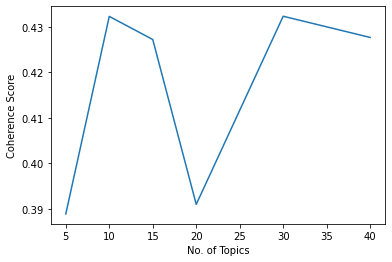

In [32]:
plt.plot(select_topics_df['No of Topics'], select_topics_df['Coherence Score'])
plt.xlabel('No. of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [144]:
# from above table we can see that best model is with no. of tpoics 10.

In [33]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [34]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"news" + 0.021*"product" + 0.020*"bbc" + 0.013*"website" + '
  '0.012*"online" + 0.011*"increase" + 0.009*"also" + 0.009*"event" + '
  '0.008*"week" + 0.008*"year"'),
 (1,
  '0.024*"على" + 0.021*"على_موجة" + 0.019*"وفي" + 0.013*"في" + 0.013*"البث" + '
  '0.010*"حتى" + 0.009*"الى" + 0.009*"سي" + 0.009*"عبر" + 0.008*"الساعة"'),
 (2,
  '0.016*"say" + 0.013*"sketch" + 0.009*"idea" + 0.006*"come" + '
  '0.006*"character" + 0.006*"premise" + 0.006*"world" + 0.006*"list" + '
  '0.006*"use" + 0.005*"take"'),
 (3,
  '0.003*"та" + 0.003*"nhung" + 0.003*"saturday" + 0.003*"japanese" + '
  '0.003*"hay" + 0.002*"новини" + 0.002*"sterilise" + 0.002*"украіни" + '
  '0.002*"на" + 0.002*"trafford"'),
 (4,
  '0.008*"say" + 0.007*"spider" + 0.006*"specie" + 0.005*"clash" + '
  '0.005*"hummus" + 0.005*"sane" + 0.005*"submission" + 0.004*"dung_beetle" + '
  '0.004*"prey" + 0.004*"dung"'),
 (5,
  '0.019*"aircraft" + 0.010*"bbc" + 0.007*"тест" + 0.005*"dan" + 0.005*"video" '
  '+ 0.005*"fm" + 0

# Visualize Topics

In [56]:
import pyLDAvis.gensim_models

In [57]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.214395 -0.212108       1        1  38.254839
8     -0.149465 -0.101262       2        1  20.575192
4     -0.094701 -0.003894       3        1  14.712876
1      0.364589 -0.196696       4        1   6.510544
0     -0.025699  0.049082       5        1   4.848314
6      0.007254  0.085087       6        1   4.368067
5      0.045219  0.127082       7        1   3.877011
7      0.016242  0.087490       8        1   3.457983
9      0.009933  0.082557       9        1   2.439756
3      0.041022  0.082662      10        1   0.955418, topic_info=        Term        Freq       Total Category  logprob  loglift
1197   write  149.000000  149.000000  Default  30.0000  30.0000
34       bbc  190.000000  190.000000  Default  29.0000  29.0000
275      use  169.000000  169.000000  Default  28.0000  28.0000
180     news  113.000000  113.000000  Default  27.0000  27.0000
5574  sketch  279.000000  279.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
4173      на    0.991296    4.017561  Topic10  -6.2898   3.2514
2646     sue    0.882559    3.895860  Topic10  -6.4060   3.1659
9064   khong    0.697337    5.625586  Topic10  -6.6416   2.5630
8279    viet    0.651944    4.750745  Topic10  -6.7089   2.6647
34       bbc    0.662285  190.370601  Topic10  -6.6931  -1.0103

[514 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11677      9  0.953856  aeronautic
2630       3  0.968904      africa
11678      9  0.953856     agencys
2654       7  0.993167    aircraft
5814       7  0.912999    al_qaeda
...      ...       ...         ...
4489       8  0.730712         करत
4407       8  0.893794         करन
4519       8  0.825589         पनन
4520       8  0.893793          पर
4548       8  0.730712       रयकरम

[753 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 5, 2, 1, 7, 6, 8, 10, 4])

In [44]:
# Finding the dominant topic and its percentage contribution in each document

In [45]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [46]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

In [47]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [48]:
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [49]:
df_dominant_topic.Dominant_Topic.value_counts()

2.0    126
4.0     49
8.0     34
5.0     21
0.0     16
1.0     16
6.0     16
7.0     14
9.0     12
3.0      4
Name: Dominant_Topic, dtype: int64

In [50]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9102,"news, product, bbc, website, online, increase,...","[head, product, bbc, news, online, lead, produ..."
1,1.0,0.9993,"على, على_موجة, وفي, في, البث, حتى, الى, سي, عب...","[حق_نشر, درک, رفتارهای, کودک, ازارانه, شناخت, ..."
2,2.0,0.9988,"say, sketch, idea, come, character, premise, w...","[pa, epa, image_caption, oligarch, roman, pm, ..."
3,3.0,0.9973,"та, nhung, saturday, japanese, hay, новини, st...","[bbc, працює, форматах, радіо, та, інтернет, д..."
4,4.0,0.9832,"say, spider, specie, clash, hummus, sane, subm...","[fotograf, ekim, devrimi, devrimin, ilk, yılla..."
